In [1]:
import sys
sys.path.append('../')

# Linear Parametric MDS

In this short example we will learn how to implement a simple parametric version of MDS using the paraDime API. We will also verify that learning a linear transformation with the MDS loss and euclidean distances leads to the same transformation matrix as the one for PCA.

We start by importing some packages and all the relevant paraDime submodules.

In [2]:
import numpy as np
import torch
import sklearn.datasets
import sklearn.decomposition
from matplotlib import pyplot as plt

import paradime.dr
import paradime.relations
import paradime.transforms
import paradime.loss

As a toy dataset for this example, we use the diabetes data from sklearn. It consists of 442 datapoints with 10 features that can be used to predict a quantitative measure of disease progression.

In [3]:
diabetes = sklearn.datasets.load_diabetes()
data = diabetes['data']

Let's first perform PCA on the dataset:

In [4]:
pca = sklearn.decomposition.PCA().fit(data)

Before we train an MDS routine, let's first verify that paraDime is working as intended. To do this, we'll check what happens when we attempt to learn a linear transformation that approximates the PCA-transformed data directly using a [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss):

In [12]:
pd_pca = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10,10,bias=False),
    verbose=True,
)
pd_pca.register_dataset({
    "data": data,
    "pca": pca.transform(data),
})
pd_pca.add_training_phase(
    epochs=20,
    batch_size=50,
    loss=paradime.loss.PositionLoss(
        position_key="pca",
        embedding_method="forward",
    ),
    report_interval=2,
)
pd_pca.train()

2022-08-29 18:34:54,789: Registering dataset.
2022-08-29 18:34:54,791: Beginning training phase 'None'.
2022-08-29 18:34:54,803: Loss after epoch 0: 0.023300415137782693
2022-08-29 18:34:54,830: Loss after epoch 2: 0.008868634060490876
2022-08-29 18:34:54,848: Loss after epoch 4: 0.003300965850939974
2022-08-29 18:34:54,868: Loss after epoch 6: 0.0015012899384601042
2022-08-29 18:34:54,886: Loss after epoch 8: 0.0007647826896572951
2022-08-29 18:34:54,907: Loss after epoch 10: 0.00038323007174767554
2022-08-29 18:34:54,935: Loss after epoch 12: 0.00019199114831280895
2022-08-29 18:34:54,959: Loss after epoch 14: 9.614360442355974e-05
2022-08-29 18:34:54,984: Loss after epoch 16: 5.0661108616623096e-05
2022-08-29 18:34:55,003: Loss after epoch 18: 2.849319571396336e-05


Let's compare the true PCA tranformation matrix and the one approximated via the [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss):

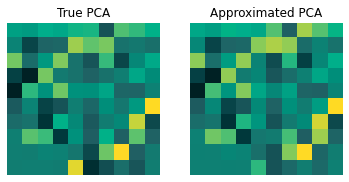

In [13]:
cmap = paradime.utils.plotting.get_colormap()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pca.components_, cmap=cmap)
ax1.set_axis_off()
ax1.set_title("True PCA")
ax2.imshow(pd_pca.model.weight.detach().numpy(), cmap=cmap)
ax2.set_axis_off()
ax2.set_title("Approximated PCA");

As expected, the matrices look very similar. Bigger differences are only visible in the bottom two rows. This makes sense, because these rows correspond to the "least important" components. Getting them wrong affects the overall positions of the tranformed data the least.

Now that we've confirmed that paraDime works correctly in this case, let's move to MDS. The loss used in MDS leads to transformed points that ideally have very similar pairwise distances as the orignal points. We implement this loss simple pairwise distances as both global and batch-wise relations (the batch ones just have to be differentiable). We compare the two distance matrices in a [RelationLoss](../api/modules.rst#paradime.loss.RelationLoss) using PyTorch's means square error implementation:

In [128]:
def mse(a, b):
    return torch.sum((a-b)**2)

In [149]:
pd_mds = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10,2,bias=False),
    global_relations=paradime.relations.PDist(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    verbose=True,
)
pd_mds.register_dataset({
    "data": data,
})
pd_mds.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    loss=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
        ),
    report_interval=50,
)
pd_mds.train()

2022-08-29 19:21:12,191: Registering dataset.
2022-08-29 19:21:12,193: Computing global relations 'rel'.
2022-08-29 19:21:12,194: Calculating pairwise distances.
2022-08-29 19:21:12,199: Beginning training phase 'None'.
2022-08-29 19:21:12,222: Loss after epoch 0: 6652.103515625
2022-08-29 19:21:13,227: Loss after epoch 50: 805.98974609375
2022-08-29 19:21:14,252: Loss after epoch 100: 739.3309936523438
2022-08-29 19:21:15,220: Loss after epoch 150: 700.6095581054688
2022-08-29 19:21:16,169: Loss after epoch 200: 669.8959350585938
2022-08-29 19:21:17,163: Loss after epoch 250: 648.2258911132812
2022-08-29 19:21:18,159: Loss after epoch 300: 635.3143310546875
2022-08-29 19:21:19,106: Loss after epoch 350: 628.0510864257812
2022-08-29 19:21:20,123: Loss after epoch 400: 624.1378784179688
2022-08-29 19:21:21,152: Loss after epoch 450: 621.8143310546875


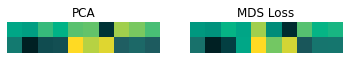

In [150]:
cmap = paradime.utils.plotting.get_colormap()
fig, (ax1, ax3) = plt.subplots(1, 2)
ax1.imshow(pca.components_[:2], cmap=cmap)
ax1.set_axis_off()
ax1.set_title("PCA")
# ax2.imshow(pd_pca.model.weight.detach().numpy(), cmap=cmap)
# ax2.set_axis_off()
# ax2.set_title("Position Loss")
ax3.imshow(np.array([[-1.], [1.]]) * pd_mds.model.weight.detach().numpy(), cmap=cmap)
ax3.set_axis_off()
ax3.set_title("MDS Loss");

<AxesSubplot:>

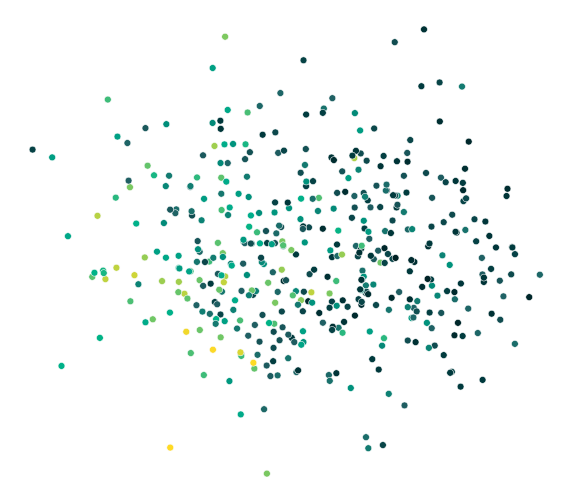

In [151]:
paradime.utils.plotting.scatterplot(
    pd_mds.apply(data),
    c=diabetes['target'],
    cmap=cmap,
)

In [85]:
from scipy.spatial.distance import pdist, squareform

<AxesSubplot:>

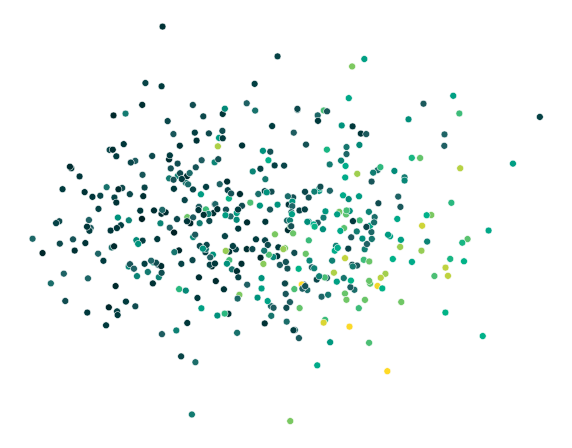

In [49]:
paradime.utils.plotting.scatterplot(
    pca.transform(data)[:,:2],
    c=diabetes['target'],
    cmap=cmap
)